# St. John's temperature data

In [ ]:
# Import neccesary libraries
import netCDF4 as nc
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import keras_tuner as kt

## Data Preprocessing

In [ ]:
# Open file
fn = "tempStJohns.nc"  # filename
ds = nc.Dataset(fn, "r")

In [ ]:
# Print metadata
print(ds)

<class 'netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2021-02-03 00:49:51 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data2/adaptor.mars.internal-1612306467.0641284-4955-27-685dbd6e-9572-4267-a9a7-5a61b7e919e4.nc /cache/tmp/685dbd6e-9572-4267-a9a7-5a61b7e919e4-adaptor.mars.internal-1612306467.0646257-4955-9-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), expver(2), time(87672)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 t2m(time, expver, latitude, longitude)
    groups: 


In [ ]:
# Print variable names and dimensions
print(ds.variables.keys())

dict_keys(['longitude', 'latitude', 'expver', 'time', 't2m'])


In [ ]:
# Two-meter temperatures
t2m = ds.variables["t2m"][:]

In [ ]:
# Selecting version 1 of t2m data
t2m_v1 = t2m[:, 0, 0, 0]

t2m_v1.shape  # data shape

(87672,)

In [ ]:
# data import verification
u = np.random.randint(87672)
t2m_v1[u]  # view samples

masked

In [ ]:
# Check for missing values
print("Number of masked values:", np.ma.count_masked(t2m_v1))

Number of masked values: 744


In [ ]:
# Fill masked values with NaN
t2m_nan = np.ma.filled(t2m_v1, fill_value=np.nan)

print("Number of masked values now:", np.ma.count_masked(t2m_nan))

Number of masked values now: 0


In [ ]:
# View last 1000 entries
t2m_nan[-1000:]

array([272.28920769, 272.18540344, 272.28147073, 272.48263176,
       272.61931809, 273.13576035, 274.3220946 , 275.1802527 ,
       275.72377432, 276.85723933, 277.55872394, 277.8675577 ,
       278.77729554, 278.82694105, 279.56839996, 279.6322299 ,
       280.0571181 , 280.22281805, 280.22926552, 280.03777569,
       279.84241739, 279.52713616, 279.39689729, 279.25892146,
       278.45556685, 278.2801957 , 278.28341943, 278.3627233 ,
       278.63867496, 279.01520714, 280.52327009, 281.25247881,
       281.74699967, 281.98491127, 281.77859227, 281.60322112,
       280.07323677, 279.91849752, 279.2814876 , 279.23893431,
       279.05195771, 278.86304688, 277.67413363, 276.9668463 ,
       276.68960515, 276.14414929, 275.87722408, 275.66058913,
       275.25568809, 275.22087175, 274.64446804, 274.57805912,
       274.61158595, 274.64059956, 274.35304245, 274.25890941,
       273.90043014, 273.55613531, 273.44588359, 273.3304739 ,
       272.25052288, 272.20087737, 271.2743761 , 271.08

In [ ]:
print(
    sum(np.isnan(t2m_nan[-1000:]))
)  # number of missing values at the latter part of the data

744


We can see that all the missing values are at the last part of the dataset.

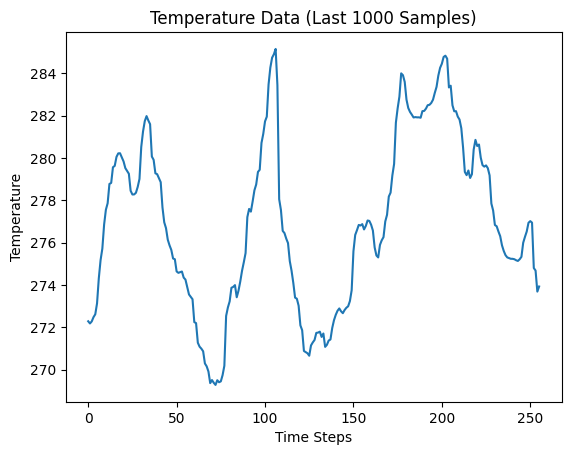

In [ ]:
plt.plot(t2m_nan[-1000:], label="Last 1000 values")
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title("Temperature Data (Last 1000 Samples)")
plt.show()

In [ ]:
# Remove nan values
t2m_clean = t2m_nan[~np.isnan(t2m_nan)]

In [ ]:
t2m_clean

array([272.81080792, 272.65671341, 272.78372855, ..., 274.6850871 ,
       273.69088741, 273.93266749])

In [ ]:
t2m_min = np.min(t2m_clean)  # Min temperature
t2m_max = np.max(t2m_clean)  # Max temperature

print(f"Maximum temperature before normalization: {t2m_max}")
print(f"Minimum temperature before normalization: {t2m_min}")

# Normalize data
t2m_norm = (t2m_clean - t2m_min) / (t2m_max - t2m_min)

print(f"Maximum temperature after normalization: {np.max(t2m_norm)}")
print(f"Minimum temperature after normalization: {np.min(t2m_norm)}")

Maximum temperature before normalization: 298.77734375
Minimum temperature before normalization: 256.525146484375
Maximum temperature after normalization: 1.0
Minimum temperature after normalization: 0.0


## Model Building

### Set window size, here!

In [ ]:
# Set window size
window = 12
# window = 24

forecast = 6  # future forecast hours

### Ground truth

In [ ]:
gt = t2m_norm[-window - forecast :]  # ground truth - 18 hours
t2m_last_x_hours = gt[:window]  # past 12 hours ignoring the 6 hours "true" values

### Persistence baseline

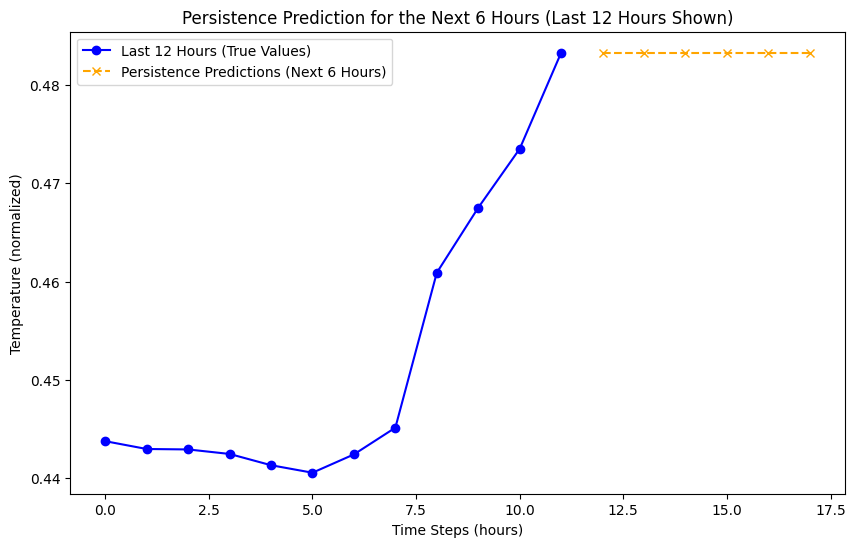

Persistence predictions for the next 6 hours: [0.48325271 0.48325271 0.48325271 0.48325271 0.48325271 0.48325271]


In [ ]:
# Last observed temperature (last value in the dataset)
last_temp = t2m_last_x_hours[-1]

# Make the persistence prediction for the next 6 hours (assuming temperature stays the same)
y_pred_pr = np.full(forecast, last_temp)

# Plot the sliced data and persistence predictions
plt.figure(figsize=(10, 6))
plt.plot(
    range(window),
    t2m_last_x_hours,
    label="Last 12 Hours (True Values)",
    color="blue",
    marker="o",
    linestyle="-",
)
plt.plot(
    range(window, window + 6),
    y_pred_pr,
    label="Persistence Predictions (Next 6 Hours)",
    color="orange",
    linestyle="--",
    marker="x",
)
plt.xlabel("Time Steps (hours)")
plt.ylabel("Temperature (normalized)")
plt.title("Persistence Prediction for the Next 6 Hours (Last 12 Hours Shown)")
plt.legend()
plt.show()

# Print the predictions for the next 6 hours
print("Persistence predictions for the next 6 hours:", y_pred_pr)

### Train-test split

In [ ]:
X = []
y = []

for i in range(len(t2m_norm) - window - forecast):
    X.append(t2m_norm[i : i + window])
    y.append(t2m_norm[i + window : i + window + forecast])

X = np.array(X)
y = np.array(y)

# Split into training and test sets
train_size = int(len(X) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Linear Regression baseline

In [ ]:
# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions for the test set
predictions = model.predict(X_test)

In [ ]:
# We can calculate the mse of the model
mse_lr = mean_squared_error(y_test, predictions)
mse_lr

0.0011367307198062403

In [ ]:
t2m_norm[-forecast:]  # last 6 hours

array([0.48509911, 0.48339005, 0.43265225, 0.42979873, 0.4062686 ,
       0.41199091])

In [ ]:
t2m_norm[-window:]

array([0.44243358, 0.44514977, 0.46089756, 0.46750492, 0.47348664,
       0.48325271, 0.48509911, 0.48339005, 0.43265225, 0.42979873,
       0.4062686 , 0.41199091])

In [ ]:
t2m_last_x_hours

array([0.44377642, 0.44298292, 0.44293715, 0.44247936, 0.4413349 ,
       0.44057193, 0.44243358, 0.44514977, 0.46089756, 0.46750492,
       0.47348664, 0.48325271])

In [ ]:
last_known_values = t2m_last_x_hours

y_pred_lr = []

# Predict the next 6 hours
for i in range(6):
    # Predict the next value
    next_prediction = model.predict(last_known_values.reshape(1, -1))
    y_pred_lr.append(next_prediction[0][0])

    # Update the last known values for the next prediction
    last_known_values = np.roll(last_known_values, shift=-1)  # Shift by 1 hour
    last_known_values[-1] = next_prediction[0][0]  # Add the predicted value

# Calculate the MSE for the linear regression model
true_values = t2m_norm[-6:]

mse = mean_squared_error(true_values, y_pred_lr)
print(f"Mean Squared Error (MSE) for Linear Regression (Next 6 Hours): {mse}")

Mean Squared Error (MSE) for Linear Regression (Next 6 Hours): 0.0038724715911654926


In [ ]:
print(f"next_prediction: {next_prediction}, shape: {next_prediction.shape}")

next_prediction: [[0.49518377 0.49380281 0.49191817 0.48668125 0.48416239 0.48175703]], shape: (1, 6)


In [ ]:
t2m_last_x_hours

array([0.44377642, 0.44298292, 0.44293715, 0.44247936, 0.4413349 ,
       0.44057193, 0.44243358, 0.44514977, 0.46089756, 0.46750492,
       0.47348664, 0.48325271])

<Figure size 1000x600 with 0 Axes>

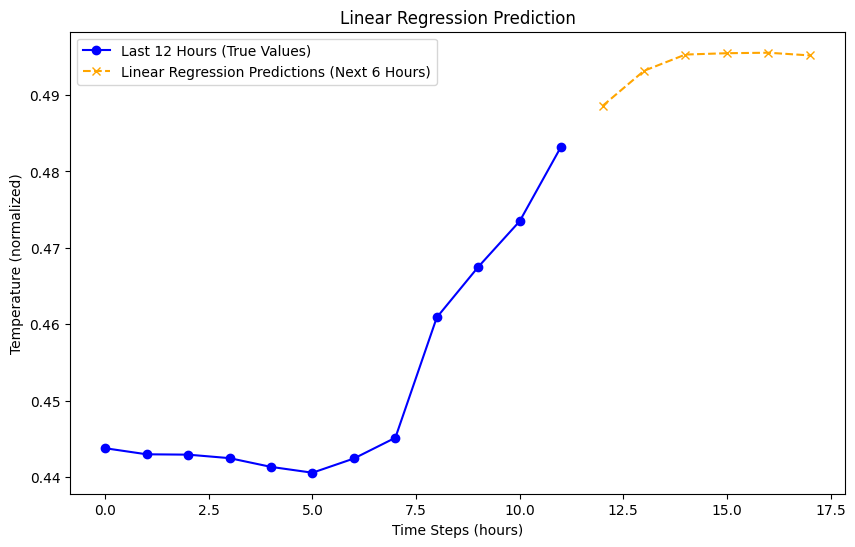

Linear Regression predictions for the next 6 hours: [np.float64(0.4885801235868996), np.float64(0.49317138860964893), np.float64(0.4952977019895171), np.float64(0.49547167862375746), np.float64(0.49553559219124155), np.float64(0.49518376642067796)]


In [ ]:
# Plot the sliced data of linear regression predictions
plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.plot(
    range(window),
    t2m_last_x_hours,
    label="Last 12 Hours (True Values)",
    color="blue",
    marker="o",
    linestyle="-",
)
plt.plot(
    range(window, window + 6),
    y_pred_lr,
    label="Linear Regression Predictions (Next 6 Hours)",
    color="orange",
    linestyle="--",
    marker="x",
)
plt.xlabel("Time Steps (hours)")
plt.ylabel("Temperature (normalized)")
plt.title("Linear Regression Prediction")
plt.legend()
plt.show()

# Print the predictions for the next 6 hours
print("Linear Regression predictions for the next 6 hours:", y_pred_lr)

In [ ]:
t2m_norm.shape

(86928,)

In [ ]:
X_train.shape

(69528, 12)

### Neural Network Predictions

In [ ]:
# Define hyperband model for tuning
def build_model(hp):

    inp = x = tf.keras.layers.Input(shape=(X_train.shape[1],))

    number_of_hidden_layers = hp.Int(
        "num_layers", 2, 4
    )  # Define the range of number of layers, here, it is from 1 to 3

    for i in range(number_of_hidden_layers):
        x = tf.keras.layers.Dense(
            hp.Int("units", min_value=16, max_value=128, step=16),
            activation="relu",
            kernel_initializer="he_normal",
        )(x)

    out = tf.keras.layers.Dense(1, activation="linear")(x)  # output layer

    # Define model
    model = tf.keras.models.Model(inp, out)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="mean_squared_error",
        metrics=["mse"],
    )

    return model

In [ ]:
tuner = kt.Hyperband(
    build_model, objective="mse", max_epochs=200, overwrite=True
)  # define how the hyperparameter tuning should occur

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# Hyperparameter searching - it is similar to the .fit method
tuner.search(X_train, y_train, validation_split=0.2, epochs=30, callbacks=[stop_early])

Trial 23 Complete [00h 00m 04s]
mse: 0.0013704075245186687

Best mse So Far: 0.0013704075245186687
Total elapsed time: 00h 01m 41s


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train, y_train, validation_split=0.2, epochs=50, callbacks=stop_early
)

test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f"\nTest loss: {test_loss}")

Epoch 1/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 2s 660us/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 2/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 3/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 4/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 5/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 6/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 7/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 8/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 9/50
1739/1739 ━━━

In [ ]:
# Summary of best model
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 48)             │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,133 (63.02 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,756 (42.02 KB)

In [ ]:
hist = pd.DataFrame(history.history)
hist.tail()

,loss,mse,val_loss,val_mse
6,0.001379,0.001379,0.001557,0.001557
7,0.001357,0.001357,0.001311,0.001311
8,0.001345,0.001345,0.001346,0.001346
9,0.001323,0.001323,0.001328,0.001328
10,0.001335,0.001335,0.001631,0.001631


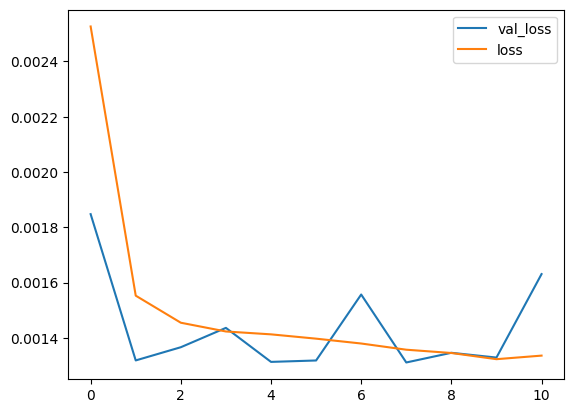

In [ ]:
plt.plot(hist.val_loss, label="val_loss")
plt.plot(hist.loss, label="loss")
plt.legend()
plt.show()

In [ ]:
# Make predictions the neural network model
predictions = best_model.predict(X_test)

# Reshape predictions to match the shape of y_test
predictions = np.tile(predictions, (1, y_test.shape[1]))

# We can calculate the mse of the NN model
mse_nn = mean_squared_error(y_test, predictions)
mse_nn

544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


0.0014404930284903246

In [ ]:
last_known_values = t2m_last_x_hours

y_pred_nn = []

# Predict the next 6 hours
for i in range(6):
    # Predict the next value
    next_prediction = best_model.predict(last_known_values.reshape(1, -1))
    y_pred_nn.append(next_prediction[0])

    # Update the last known values for the next prediction
    last_known_values = np.roll(last_known_values, shift=-1)  # Shift by 1 hour
    last_known_values[-1] = next_prediction.item()  # Add the predicted value

# Calculate the MSE for the linear regression model
true_values = t2m_norm[-6:]

mse = mean_squared_error(true_values, y_pred_nn)
print(f"Mean Squared Error (MSE) for Neural Network (Next 6 Hours): {mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Mean Squared Error (MSE) for Neural Network (Next 6 Hours): 0.03598309214311566


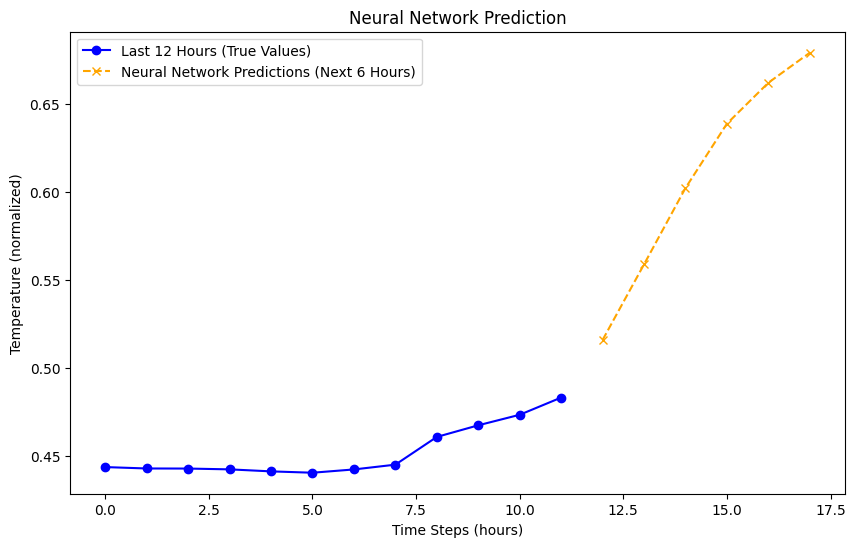

Neural Network predictions for the next 6 hours: [array([0.51596856], dtype=float32), array([0.5588954], dtype=float32), array([0.602258], dtype=float32), array([0.6388058], dtype=float32), array([0.66207165], dtype=float32), array([0.6791225], dtype=float32)]


In [ ]:
# Plot the sliced data of neural network predictions
plt.figure(figsize=(10, 6))
plt.plot(
    range(window),
    t2m_last_x_hours,
    label="Last 12 Hours (True Values)",
    color="blue",
    marker="o",
    linestyle="-",
)
plt.plot(
    range(window, window + 6),
    y_pred_nn,
    label="Neural Network Predictions (Next 6 Hours)",
    color="orange",
    linestyle="--",
    marker="x",
)
plt.xlabel("Time Steps (hours)")
plt.ylabel("Temperature (normalized)")
plt.title("Neural Network Prediction")
plt.legend()
plt.show()

# Print the predictions for the next 6 hours
print("Neural Network predictions for the next 6 hours:", y_pred_nn)

### Mean squared error verification

In [ ]:
t2m_last_x_hours

array([0.44377642, 0.44298292, 0.44293715, 0.44247936, 0.4413349 ,
       0.44057193, 0.44243358, 0.44514977, 0.46089756, 0.46750492,
       0.47348664, 0.48325271])

In [ ]:
gt  # ground truth

array([0.44377642, 0.44298292, 0.44293715, 0.44247936, 0.4413349 ,
       0.44057193, 0.44243358, 0.44514977, 0.46089756, 0.46750492,
       0.47348664, 0.48325271, 0.48509911, 0.48339005, 0.43265225,
       0.42979873, 0.4062686 , 0.41199091])

In [ ]:
past_12_hours = gt[:12]  # past 12 hours ignoring the 6 hours "true" values
pr = np.concatenate((past_12_hours, y_pred_pr))  # persistence model
lr = np.concatenate((past_12_hours, y_pred_lr))  # linear regression
nn = np.concatenate((past_12_hours, np.array(predictions).flatten()))  # neural network

In [ ]:
next_forecast_hours_gt = gt[window:window + forecast]  # Ground truth for the next 6 hours

mse_pr = []
mse_lr = []
mse_nn = []

# mse at each prediction step
for i in range(1, 7):
    mse_pr.append(mean_squared_error(next_forecast_hours_gt[:i], pr[window : window + i]))
    mse_lr.append(mean_squared_error(next_forecast_hours_gt[:i], lr[window : window + i]))
    mse_nn.append(mean_squared_error(next_forecast_hours_gt[:i], nn[window : window + i]))

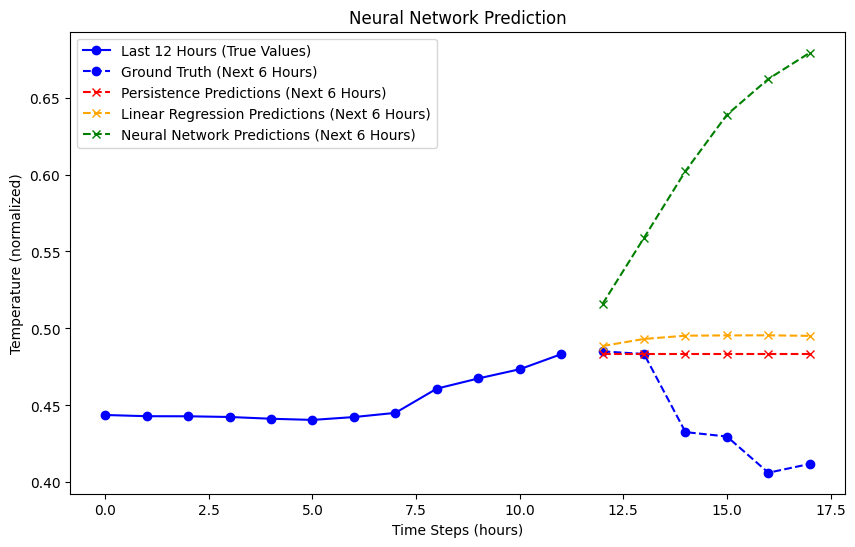

Neural Network predictions for the next 6 hours: [array([0.51596856], dtype=float32), array([0.5588954], dtype=float32), array([0.602258], dtype=float32), array([0.6388058], dtype=float32), array([0.66207165], dtype=float32), array([0.6791225], dtype=float32)]


In [ ]:
# Plot all predictions
plt.figure(figsize=(10, 6))
plt.plot(
    range(window),
    t2m_last_x_hours,
    label="Last 12 Hours (True Values)",
    color="blue",
    marker="o",
    linestyle="-",
)
plt.plot(
    range(window, window + 6),
    true_values,
    label="Ground Truth (Next 6 Hours)",
    color="blue",
    marker="o",
    linestyle="--",
)
plt.plot(
    range(window, window + 6),
    y_pred_pr,
    label="Persistence Predictions (Next 6 Hours)",
    color="red",
    linestyle="--",
    marker="x",
)
plt.plot(
    range(window, window + 6),
    y_pred_lr,
    label="Linear Regression Predictions (Next 6 Hours)",
    color="orange",
    linestyle="--",
    marker="x",
)
plt.plot(
    range(window, window + 6),
    y_pred_nn,
    label="Neural Network Predictions (Next 6 Hours)",
    color="green",
    linestyle="--",
    marker="x",
)
plt.xlabel("Time Steps (hours)")
plt.ylabel("Temperature (normalized)")
plt.title("Neural Network Prediction")
plt.legend()
plt.show()

# Print the predictions for the next 6 hours
print("Neural Network predictions for the next 6 hours:", y_pred_nn)

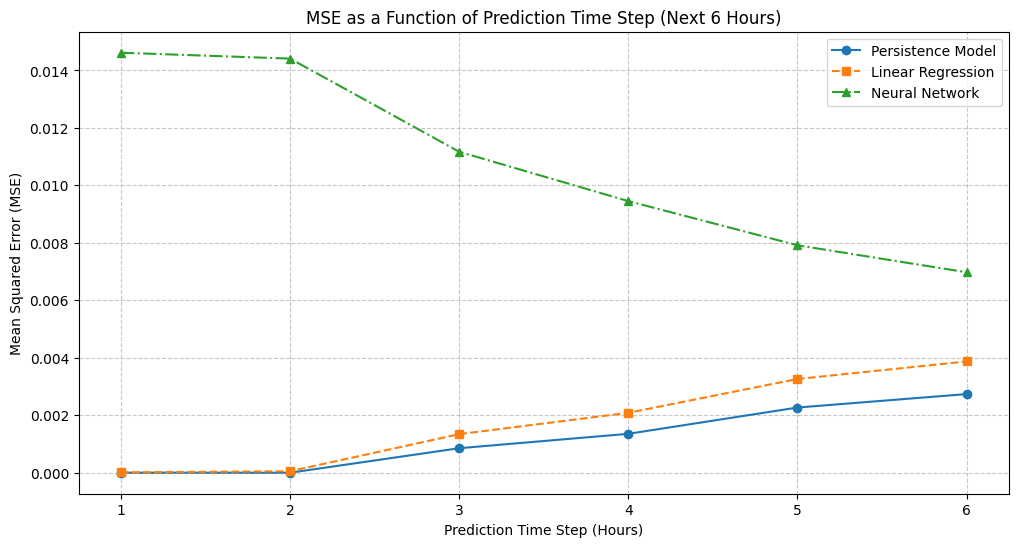

In [ ]:
plt.figure(figsize=(12, 6))

# Plot mse for each model at each time step
plt.plot(range(1, 7), mse_pr, label="Persistence Model", marker="o", linestyle="-")
plt.plot(range(1, 7), mse_lr, label="Linear Regression", marker="s", linestyle="--")
plt.plot(range(1, 7), mse_nn, label="Neural Network", marker="^", linestyle="-.")

plt.xlabel("Prediction Time Step (Hours)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE as a Function of Prediction Time Step (Next 6 Hours)")
plt.xticks(range(1, 7))
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()

In this time series forecasting task, I compared the performance of a neural network model against two baselines - persistence and linear regression. The results indicate that the neural network underperforms relative to both baselines. 

There are some reasons why I think this is happening:

1. The persistence model assumes that future values will be the same as the most recent observation—a surprisingly strong baseline for short-term forecasting tasks. Similarly, linear regression, with its simplicity and low variance, is well-suited for problems with linear trends and minimal complexity.
2. It is likely that the architecture being used here is not the most effective way of solving this kinds of problems. LSTM and GRU may yield better results.